# Variational Auto Encoder in pyTorch for MNIST dataset

## Overview

The basic idea of a Variational Auto Encoder (VAE) is shown below:

 <img src="vae1.png">
 
Hopefully, this cartoon should convey a couple of important ideas:
1. the VAE is composed of a (probabilistic) Encoder and a (probabilistic) Decoder which do NOT need to have the same architecture (represented by boxes of different color and shapes)
2. the output of the VAE is probabilistic. So it is often usefull to visualize the expected (i.e. averaged) output.
3. the input and the expected output of the VAE are NOT identical (the difference between input and output is greatly exagerated just for making the poiunt clear)
 
The encoder compress the input $x$ into a latent variable $z$ which lives in small dimensions latent space. The decoder tries to recover the original image from the latent space representation. 
 
We now zoom-in in the central part of the figure and clarify what we mean by **probabilistic encoder**.   
 
 <img src="vae2.png">

The important feature is that the latent variable $z=\mu+\sigma \epsilon$ is a random variable since $\epsilon$ is itself a random variable distribuited according to a normal distribution $p(\epsilon)=N(\epsilon|0,I)$. This means that each input vector $x$ can be mapped into many differrent values of $z$, i.e. we have a **probabilistic encoder**. Fortunately, these value of $z$ are all close to each other (i.e. they are centered around $\mu$ and have a spreading of size $\sigma$). 

From the figure above we can easily read off the core of the pyTorch implementation of the VAE:

We will train the VAE by demanding that the reconstruction error is small (i.e. the input $x$ and output $\tilde{x}$ are close to each other according to some proper metric) This requirement, together with the use of a **probabilstic encoder**, imposes a nice structure on the latent space. To understand this imagine that two inputs $x_1$ and $x_2$ representing two different digits (for example a $0$ and a $7$) were mapped to similar values of $\mu$ and $\sigma$ by the encoder. Then we would calculate:

$$z_1=\mu_1+\sigma_1 \epsilon_1,\quad\text{and}\quad z_2=\mu_2+\sigma_2 \epsilon_2$$

Since $\epsilon\sim N(0,I)$ is a random variable it is possible that $z_1=z_2$ (or more precisely that $z_1$ and $z_2$ are arbitrarely close to each other). Then when we feed this into the decoder, it would be impossible for it to decide wheather to generate a $0$ or a $7$ and the recontruction error would be (on average) very large. The only way to avoid this problem is for the encoder to learn how to map different inputs (for example a $0$ and a $7$) into different regions of the latent space and conversely to map similar inputs (for example two different version of a $0$) into close-by regions in the latent space. 

We will now describe in detail how this works. As an example we will use the MNIST dataset of handwritten digits. The VAE will take as input 28 x 28 gray scale images and will simultaneously learn:
1. to compress the input vector $x$ in $D_x=728$ dimensions (obtained by flattening the $28 \times 28$ images) into a hidden variables $z$ in a low dimensional space, for example $D_z=2$. 
2. to generate a $D_x$ dimensional output vector $\tilde{x}$ for each particular value of the hidden variable $z$.

As we have already seen, the VAE is composed of a **stochastic encoder** which maps $x\to z$ and a **stochasitc decoder** which maps $z \to \tilde{x}$. We will train the VAE by:
1. demanding that the reconstruction error is small, i.e. $\tilde{x}$ and $x$ are similar to each other (according to a proper metric) 
2. enforcing a suitable structure in the latent space. This is important since we eventually want to sample the latent space and use the decoder to generate new (never seen before) images. This is only possible if we know how to meaningfully sample the latent space which in turns requires that the latent space has some "structure".

## Mathematical Preliminaries

We start by showing three mathematical identities:

\begin{equation}
\log p(X)=\int dZ q(Z)\log p(X) = \int dZ q(Z) \log \frac{p(X,Z)}{p(Z|X)}  \\
= \int dZ q(Z) \log \frac{p(X,Z)}{q(Z)} + \int dZ q(Z) \log \frac{q(Z)}{p(Z|X)} \\ 
= ELBO + KL(q(Z)\,||\,p(Z|X))
\end{equation}

where $KL(a(.)\,||\,b(.))$ is the KL divergence between the two distribution $a(.)$ and $b(.)$ which is always positive and becomes zero only when $a(.)=b(.)$. From equation (1) and the positivity of the KL divergence it immediately follows that:

\begin{equation}
\log p(X) \ge ELBO 
\end{equation}

We can rewrite ELBO as:

\begin{equation}
ELBO \equiv \int \,dz \,q(Z)\,\log \frac{p(X,Z)}{q(Z)} = \int \,dz \,q(Z)\,\log \frac{p(X|Z)p(Z)}{q(Z)} = E_{q(Z)} [\log p(X|Z)] - KL(q(Z)\,||\,p(Z))
\end{equation}

where 

$$E_{q(Z)} [\log p(X|Z)] \equiv \int \,dZ \,q(Z)\,\log p(X|Z)$$ 

At this point, the equations 1,2,3 are not very usefull and might seem a little arbitrary since ELBO (Evidence Lower Bound) could also be written as the negative of the KL divergence between $q(Z)$ and $p(X,Z)$. Interestingly the equations above remain true even when the distributions depend on some parameters. When this is the case these equations can be used to:
1. to find the value of the parameters which maximize the probability of observing the data (this is known as Expectation-Maximization algorithm) or 
2. to approximate the true posterior distribution in terms of a variational family of distribution (Bayesian Variational Inference).



## Probabilistic Decoder (i.e. $z\to \tilde{x}$)

The task of the probabilistic decoder is to take a hidden variable $z$ in $D_z$ dimension and transform it into an output vector $\tilde{x}$ in $D_x$ dimension. In mathematical terms the probabilistic decoder is defined by:

\begin{equation}
p_\theta(\tilde{x})=p_\theta(\tilde{x}|z)p(z)
\end{equation}

where $p(z)$ is the prior for the hidden variable $z$ which is chosen to be a multidimensional normal distribution with zero average and unit variance:

\begin{equation}
p(z)=N(z|0,I),\quad\text{where $I$ is the identity matrix in $D_z$ dimension}
\end{equation}

and $p_\theta(\tilde{x}|z)$ is the likelyhood which descibes the probability, under the current model, that the hidden variables $z$ generate the output $\tilde{x}$. This probability depends on the model under consideration. For us the model is a Neural Network (NN). The parameters of the NN are collectively indicated by $\theta$. In the equation above, the term on the LHS is known as the EVIDENCE which is the probability of observing the data under the current model. Clearly we should optimize the parameters $\theta$ so that the EVIDENCE is maximized (more of this later).

To be concrete, we will use a NN with a single hidden layer. Therefore $p_\theta(\tilde{x}|z)$ is built explicitely in the following way:

\begin{equation} 
a_2 = relu(W_1 z + b_1) \\
a_3 = sigmoid(W_2 a_2 + b_2) \\
p(\tilde{x}|a_3) = a_3^\tilde{x}(1-a_3)^{(1-\tilde{x})}
\end{equation}

In other words, the latent variable $z$ is fed into a NN with two dense layers. The output of the NN is a vector $a_3$ containing $D_x$ probabilities (i.e. the dimensionality of the MNIST images). Each entry in $a_3$ bescribes the probability that a particular pixel in the image $\tilde{x}$ is black $\tilde{x}_i=0$ or white $\tilde{x}_i=1$. Clearly this is a Bernulli distribution therefore the expected value of $\tilde{x}$ is:

$$ E[\tilde{x}] = \sum_{\tilde{x}=0,1} \tilde{x} p(\tilde{x}|a_3) = 0\times(1-a_3)+1\times a_3 = a_3 $$

Therefore to visualize the average output we can simply image the probabilities $a_3$.
The parameters of the decoder NN are $\theta=\{W_1,b_1,W_2,b_2\}$. 

As a side, we note that:

\begin{equation} 
\log p(\tilde{x}|a_3) = \sum_i \tilde{x}_i \log (a_3)_i + (1-\tilde{x}_i) \log (1-(a_3)_i) 
\end{equation} 

is just the binary cross entropy between $\tilde{x}$ and $a_3$.

## Probabilistic Encoder (i.e. $x\to z$)

The task of the probabilistic encoder is to take a input vector $x$ in $D_x$ dimension and compress it into the hidden variables $z$ in $D_z$ dimensions. Mathematically the probabilistic encoder is defined by the posterior $p_\theta(z|x)$ which describes the probability that an input vector $x$ is mapped to a particular value $z$ in the latent space. In principle the posterior can be learned using the Baysian framework:

\begin{equation}
p_\theta(z|x)=\frac{p_\theta(x|z)p(z)}{p_\theta(x)}
\end{equation}

where all the term on the RHS have been introduced when discussing the probabilistic decoder. The expression above is the mathematically way of expressing the fact that the encoder and decoder are complementary to each other. For the problem at hand, the equation above is intractable (both analytically and computationally). This is analytically intractable because we do not have an analitical form for $p_\theta(x|z)$ since this is encoded in a NN. Moreover this is computationally intractable since in the EVIDENCE ($p_\theta(x)=\int dz p_\theta(x|z)p(z)$) which appears in the denominator is exponentially hard to compute in the dimension of the hidden space $D_z$. 

We are therefore force to use Approximate Bayesian Inference. We approximate the true posterior $p_\theta(z|x)$ by a variational family $q_\phi(z|x)$. Here we restrict ourself to the family of Gaussian posterior $q(z|x)=N(z\,|\,\mu(x),diag(\sigma(x)))$. In principle, for each $x$ we would need to learn $\mu(x)$ and $\sigma(x)$. However, in this case the number of parameters scales with the dataset size which is a BAD idea. Instead we use an inference network descibed by the parameters $\phi$ which will learn how to map $x$ to $\mu(x)$ and $\sigma(x)$. This is called **amortization**. 

To be concrete we choose the inference network to be a NN with a single hidden layer:

\begin{equation}
a_x=relu(W_x x + b_x) \\
\mu_z = W_\mu a_x + b_\mu \\
\log\sigma_z = W_\sigma a_x + b_\sigma
\end{equation}

In other words, the input variable $x$  is fed into a NN with two dense layers. The output of the NN are two vectors of dimension $D_z$. One containts the average and the other the variance (actually the log variance) of the Normal distribution. The parameters of this inference network are $\phi=\{W_x,b_x,W_\mu,b_\mu,W_\sigma,b_\sigma\}$. The output of the inference network are $\mu_\phi(x),\sigma_\phi(x)$ which are used to build the approximate posterior:

\begin{equation}
q_\phi(z|x)=N(z\,|\,\mu_\phi(x),diag(\sigma_\phi(x)))
\end{equation}

## Loss Function

We now rewrite the inital three equations making sure to keep track of all the parameters we have introduced thus far:

\begin{equation}
\log p_\theta(x)= ELBO(\theta,\phi) + KL(q_\phi(z|x)\,||\,p_\theta(z|x)) 
\end{equation}
\begin{equation}
\log p_\theta(x) \ge ELBO(\theta,\phi) 
\end{equation}
\begin{equation}
ELBO(\theta,\phi) = E_{q_\phi(z|x)} [\log p_\theta(x|z)] - KL(q_\phi(z|x)\,||\,p(z)) 
\end{equation}

As a recap:
1. $p(z)=N(z | 0,I)$ is the prior for the hidden variables
2. $p_\theta(x|z)$ and $p_\theta(x)$ are the "likelihood" and "evidence" which depend on the parameters $\theta=\{W_1,b_1,W_2,b_2\}$ of the decoder NN.
3. $p_\theta(z|x)$ is the true posterior which is not accessible to us (i.e. the problem is intractable)
3. $q_\phi(z|x)$ is the approximate posterior which is given by gaussian family $q_\phi(z|x)=N(z\,|\,\mu_\phi(x),\sigma_\phi(x))$ where $\mu_\phi(x)$ and $\sigma_\phi(x)$ are the output of the inference NN which depend on the parameters $\phi=\{W_x,b_x,W_\mu,b_\mu,W_\sigma,b_\sigma\}$.

Our goal is now to maximize the evidence (or equivalently the log-evidence since the log is a monothonic function), i.e. maximize the probability of observing the data under the current model. Unfortunately the log-evidence depends on the true posterior (see Eq. 11) which is unaccessible to us. Eq. 12 states that the ELBO is a lower bound for the evidence (this justifies its name) therefore we decide to maximize the ELBO as a proxi for the maximization of the evidence. The ELBO depends on the parameters $\theta$ in the decoder NN and $\phi$ in the inference NN. Note that:
1. when we maximize ELBO w.r.t. $\phi$ we are reducing $KL(q_\phi(z|x)\,||\,p_\theta(z|x))$ (this can be seen by noticing that the LHS in Eq. 11 is independent on $\phi$ therefore increasing ELBO must be accompanied by a reduction in KL) and therefore making the approximate posterior more similar to the true posterior 
2. when we maximize ELBO w.r.t. $\theta$ we are most likely pushing the evidence higher and therefore making the model more tuned to the observed data. 

Therefore maximizing the ELBO with respect to both $\theta$ and $\phi$ is a very desirable thing to do.

In a Machine Learning framework we are usually trying to minimize the loss function. If we are interested in maximizing the ELBO we can simply set:

\begin{equation}
Loss=-ELBO(\theta,\phi)=Loss_1+Loss_2 
\end{equation}

where $Loss_1$ and $Loss_2$ correspond to the two terms (the KL and the Expected Log Likelyhood) in the ELBO. Conceptually, we are done. Practically, we still need to "massage" the ELBO expression a bit in order to write it as a simple analytical function of the outputs of the decoder NN and inference NN. This is a necessary step if we want to use modern ML framework (such as Keras, pyTorch etc) which need to be able to automatically compute the derivatives of the Loss function and backpropagate to update the parameters $\phi,\theta$. 

Let us start with the KL divergence term in the ELBO. Since both the prior $p(z)=N(z\,|\,0,I)$ and the approximate posterior $q_\phi(z|x)=N(z\,|\,\mu_\phi(x),\sigma_\phi(x))$ are gaussian then it is easy to compute the KL term analytically:

$$ Loss_1 = KL(q_\phi(Z|X)\,||\,p(Z)) = -\frac{1}{2} \sum_{k=1}^{D_z} \left(1+\log\sigma^2(x)_k- \mu(x)^2_k - \sigma^2(x)_k \right) $$

Note that this expression above is a simple (analytical) function of outputs of the inference network ($\mu_\phi(x),\sigma_\phi(x)$) therefore this expression is ready for use in ML framework based on backpropagation. **This part of the Loss function encorauges the posterior distribution to be close to the prior and can be interpreted as a regularization term which prevent the parameters $\mu_\phi(x)$ and $\sigma_\phi(x)$ from becoming to different from $0$ and $1$ respectively.**

The second term in the ELBO is the Expected Log Likelyhood (ELL):

$$Loss_2 = - ELL(\theta,\phi) = - E_{q_\phi(z|x)} [\log p_\theta(x|z)] = - \int dz\,q_\phi(z|x)\,\log p_\theta(x|z) $$

This expression is **not** simple enough to be used directly for backpropagation. Note that this expression involves an integral over the distribution $q_\phi(z|x)$ which depend on the parameter $\phi$ which we are trying to optimize. Interestingly, the expression above can be rewritten exactly as:

$$ Loss_2= - \int dz\,q_\phi(z|x)\,\log p_\theta(x|z) = - \int d\epsilon\,N(\epsilon|0,I)\,\log p_\theta(x|\mu_\phi(x)+\sigma_\phi(x) \epsilon)$$

The equivalence between the two expressions can be seen by thinking about the "Monte-Carlo way" of computing these integrals. The first expression can be computed by:
1. drawing multiple $z$ from the distribution $q_\phi(z|x)=N(z\,|\,\mu_\phi(x),\sigma_\phi(x))$ 
2. then using those values to compute $\log p_\theta(x|z)$.

The second expression can be computed by:
1. draw multiple $\epsilon$ from the distribution $N(0,I)$
2. use those value of $\epsilon$ to compute $z=\mu_\phi(x)+\sigma_\phi(x) \epsilon$
3. compute $\log p_\theta(x|z)$

It is easy to see that, if $\epsilon\sim N(0,I)$ then $z=\mu_\phi(x)+\sigma_\phi(x) \epsilon\sim N(z\,|\,\mu_\phi(x),\sigma_\phi(x))=q_\phi(z|x)$ and therefore steps 1 and 2 are equivalent to draw $z$ from the distribution $q_\phi(z|x)$. This means that the two expressions for $Loss_2$ are equivalent.

The final step is to approximate the integral over $d\epsilon$ with a single Monte Carlo sample, i.e.:

$$ Loss_2 \approx - \log p_\theta\left(x|\mu_\phi(x)+\sigma_\phi(x) \epsilon\right),\quad\text{where}\quad \epsilon\sim N(0,I)$$

We have finally reached an expression simple enough to be used in ML framework based on backpropagation. **The ELL term in the Loss function is the reconstruction error. It encourages the encoder and the decoder to be inverse of each other.** To see this imagine that a region in the latent space is mapped to a region in the original space , i.e. $p_\theta(x|z)$ is high among those two regions. The $Loss_2$ will be small if  $q_\phi(z|x)$ is high among those same two regions. So we can say that, at the end of training, the mapping from $z\to x$ described by $p_\theta(x|z)$ is opposite to the mapping from $x\to z$ described by $q_\phi(z|x)$.

### Raparametrization Trick

More formally, the manipulation that we have done in the ELL, is known as reparametrization trick. The reparameterization trick is a straightforward change of variables that expresses the random variable $z\sim q_\phi(z|x)$ as a deterministic transformation $g_\phi(x,\epsilon)$ of the input $x$ and another random variable $\epsilon$ with parameters $\phi$:

$$ z=g_\phi(x,\epsilon),\quad \epsilon\sim p(\epsilon) $$

Note that $p(\epsilon)$ is parameter-free and independent $x$ and $\phi$ then, for any function $f(x,z)$ we then have:

$$ E_{q_\phi(z|x)} \left[f(x,z)\right] = E_{\epsilon} \left[f\left(x,g_\phi(x,\epsilon)\right)\right] \approx f\left(x,g_\phi(x,\epsilon)\right),\quad\text{with}\quad \epsilon\sim p(\epsilon)$$

the advantage of this reparametrization is that now the parameter $\phi$ appears in the integrad but not in the distribution with respect to which the intrand is computed. In the final step we have replaced the expecatation value with a sigle Monte Carlo drawn. **Note that, in general, the change of variable form $z\to\epsilon$ lead to the introduction of a Jacobian.**

## Implementation of VAE using pyTorch

The equations for the encoder are:
$$
a_x=relu(W_x x + b_x) \\
\mu_z = W_\mu a_x + b_\mu \\
\log\sigma_z = W_\sigma a_x + b_\sigma
$$
where $x$ has dimension $D_x$, $a_x$ has dimension $D_\text{hidden_encoder}$ and $z$ has dimension $D_z$

The equation for the decoder are:
$$ 
a_2 = relu(W_1 z + b_1) \\
a_3 = sigmoid(W_2 a_2 + b_2) \\
p(\tilde{x}|a_3) = Bern(\tilde{x},a_3) = a_3^{\tilde{x}} (1-a_3)^{(1-\tilde{x})} 
$$
where $z$ has dimension $D_z$, $a_2$ has dimension $D_\text{hidden_decoder}$ and $a_3$ has the same dimension as $D_x$.

The way that encoder and decoder are coupled together is:
$$
\mu_z, \log\sigma_z = \text{encoder}(x_\text{input}) \\
\sigma_z = \exp\left[\log\sigma_z\right] \\
\epsilon \sim N(0,I) \\
z = \mu_z + \sigma_z * \epsilon \\
x_\text{output} = \text{decoder}(z)
$$

Let us implement this in pyTorch now!

### Let's start by importing some packages and define helper functions

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline


# Decide if the system has GPUs
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)
print(dtype)

def save_everything(model_object,filepath):
    """
    Simple function to save everything to file
    """
    state={
        'state_dict': model_object.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, filepath)
    
def load_everything(model_object,filepath):
    """
    Simple function to load everything from file
    """
    state = torch.load(filepath)
    model_object.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])    

def show_batch(images):
    """
    Simple function to show the images
    """
    im = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

cuda
<class 'torch.cuda.FloatTensor'>


## Define the Encode, Decoder and CAE class

In [2]:
# Define the encoder class by specifying its layers and the connections between layers
class Encoder(torch.nn.Module):
    def __init__(self, DIM_x, DIM_hidden_encoder, DIM_z):
        super().__init__()
        self.linear1 = torch.nn.Linear(DIM_x, DIM_hidden_encoder)
        self.z_mu = torch.nn.Linear(DIM_hidden_encoder, DIM_z)
        self.z_log_sigma2 = torch.nn.Linear(DIM_hidden_encoder, DIM_z)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        z_mu = self.z_mu(x)
        z_log_sigma2 = self.z_log_sigma2(x)
        return z_mu,z_log_sigma2
    
# Define the encoder class by specifying its layers and the connections between layers
class Decoder(torch.nn.Module):
    def __init__(self, DIM_z, DIM_hidden_decoder, DIM_x):
        super().__init__()
        self.linear1 = torch.nn.Linear(DIM_z, DIM_hidden_decoder)
        self.linear2 = torch.nn.Linear(DIM_hidden_decoder, DIM_x)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        a3= torch.sigmoid(self.linear2(z))   
        return a3 
    
# Define the encoder VAE class by combining encoder and decoder
class VAE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_history = []
        self.epoch = 0 
        self.training_time = 0
        self.BCE_loss = torch.nn.BCELoss(reduction='sum') 

    def forward(self, x_input):
        
        # encoder
        z_mu, z_log_sigma2 = self.encoder(x_input)
        
        # connection between encoder and decoder
        z_sigma = torch.exp(0.5*z_log_sigma2)
        if(device == 'cpu'): ### create a random variable on cpu
            epsilon = dtype.from_numpy(np.random.normal(0, 1, size=z_sigma.size())) #N(0,I)
        else: ### create a random variable on cuda
            epsilon = dtype(size=z_sigma.size()).normal_()
        z = z_mu + z_sigma * Variable(epsilon, requires_grad=False) # Reparameterization trick
        
        # decoder
        x_output = self.decoder(z)
        return x_output, z_mu, z_log_sigma2 
    
    def compute_loss(self, x_input, x_output, z_mu, z_log_sigma2):
        # binary cross entropy
        BCE = self.BCE_loss(x_output,x_input) #Binary cross entropy between output and target
        #tmp = x_output-x_input
        #BCE = torch.sum(tmp*tmp)
        # KL divergence
        z_sigma2 = torch.exp(z_log_sigma2)
        KLD = 0.5 * torch.sum(z_sigma2 + z_mu.pow(2) - 1 - z_log_sigma2)
        #print("BCE, KLD",BCE.item(),KLD.item())
        return BCE+KLD
        
    
    def train_one_epoch(self,trainloader):
        
        tmp = [] 
        for i, data in enumerate(trainloader, 0): #loop over minibatches
            
            # Get images and flatten them into vectors
            images_in, labels  = data
            images_in = images_in.to(device) #put the data on GPU if necessary
            x_input = Variable(images_in.view(-1,DIM_x),requires_grad=False)
            
            # Run the VAE forward 
            x_output, z_mu, z_log_sigma2 = vae(x_input)
            #print("xout",x_output.dtype)
            #print("xout",x_output.device)
            
            # Compute the loss
            loss = vae.compute_loss(x_input, x_output, z_mu, z_log_sigma2)
            #print("loss",loss.dtype)
            #print("loss",loss.device)
            
            # compute the average loss in this epoch
            tmp.append(loss.item()) # add the loss to the tmp list
            
            # For each minibatch set the gradient to zero
            optimizer.zero_grad()
            loss.backward()  # do backprop and compute all the gradients
            optimizer.step() # update the parameters
            
        # Svae the average loss during the epoch and the final value at the end of epoch
        self.loss_history.append(np.mean(tmp))
        self.epoch += 1
        
        
    def train(self,trainloader,DELTA_EPOCHS):
        import timeit
        tic=timeit.default_timer()
        
        for nn in range(DELTA_EPOCHS):
            vae.train_one_epoch(trainloader)
            print("EPOCH loss=",vae.epoch,vae.loss_history[-1])
        
        toc=timeit.default_timer()
        self.training_time += toc - tic

   
    def evaluate(self,trainloader):
        with torch.no_grad():   
            images_in, labels  = next(iter(trainloader))
            x_input = images_in.view(-1,DIM_x).to(device)
            x_output, z_mu, z_log_sigma = vae(x_input)
            out_reshaped = x_output.view(-1,1,height, width)
            images_out = out_reshaped.cpu()         
        return images_in,images_out          

### Run the model

In [3]:
if __name__ == '__main__':
    
   
    BATCH_SIZE = 64

    # torchvision.datasets.MNIST outputs a set of PIL images
    # We transform them to tensors
    transform = transforms.ToTensor()
    #transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

    # Load and transform data
    trainset = torchvision.datasets.MNIST('/home/ldalessi/VAE/data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = torchvision.datasets.MNIST('/home/ldalessi/VAE/data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    # Visualize the data and extract the image size
    images, labels =next(iter(trainloader))
    _, _, height, width = images.size()
   
    # The other dimensions are arbitrary and chosen by user
    DIM_x              = height*width
    DIM_z              = 2
    DIM_hidden_encoder = 256
    DIM_hidden_decoder = 128
      
    # Create instances of Encoder, Decoder and VAE on either GPU or CPU
    encoder = Encoder(DIM_x, DIM_hidden_encoder, DIM_z).to(device)
    decoder = Decoder(DIM_z, DIM_hidden_decoder, DIM_x).to(device)
    vae = VAE(encoder, decoder).to(device) #note that here I am creating the model to either gpu or cpu
    
    # Select the optimizer
    #optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    optimizer = optim.RMSprop(vae.parameters())

    

In [4]:
    for k in range(19,20):
        if(k>0):
            load_everything(vae,'./vae_'+str(k-1)+'.pth')
        
        vae.train(trainloader,10)  # train the model for 10 EPOCHS 
        save_everything(vae,'./vae_'+str(k)+'.pth')
        images_in,images_out = vae.evaluate(trainloader)

        if(k==0):
            save_image(images_in,'./input.png')
        save_image(images_out,'./output_' + str(vae.epoch) + '.png')
        

EPOCH loss= 1 10047.297066043942
EPOCH loss= 2 10044.093815069464
EPOCH loss= 3 10042.595871785048
EPOCH loss= 4 10047.624083821962
EPOCH loss= 5 10049.693388005564
EPOCH loss= 6 10040.82120056803
EPOCH loss= 7 10045.560970086786
EPOCH loss= 8 10046.170587145189
EPOCH loss= 9 10039.105921633462
EPOCH loss= 10 10044.6122682486


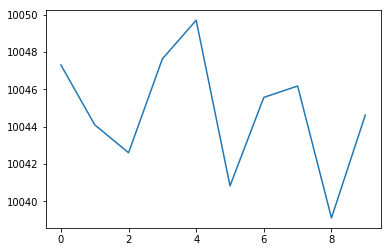

In [5]:
plt.plot(vae.loss_history)
images_in,images_out = vae.evaluate(trainloader)

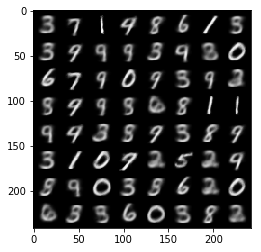

In [6]:
show_batch(images_out)

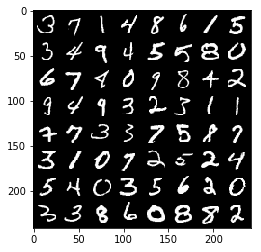

In [7]:
show_batch(images_in)

In [8]:
vae.state_dict()

OrderedDict([('encoder.linear1.weight',
              tensor([[ 0.0328,  0.0046, -0.0231,  ..., -0.0276,  0.0356, -0.0248],
                      [-0.0259, -0.0293, -0.0347,  ..., -0.0119, -0.0339, -0.0310],
                      [-0.0041,  0.0348,  0.0105,  ..., -0.0010,  0.0062, -0.0058],
                      ...,
                      [-0.0027,  0.0197,  0.0325,  ..., -0.0066,  0.0113,  0.0210],
                      [-0.0034, -0.0273, -0.0152,  ...,  0.0255, -0.0122,  0.0178],
                      [ 0.0079, -0.0162,  0.0070,  ..., -0.0046, -0.0259,  0.0010]],
                     device='cuda:0')),
             ('encoder.linear1.bias',
              tensor([-1.0730e-01, -1.3248e-01, -1.2607e-01, -7.7824e-02, -2.0404e-01,
                      -1.1687e-01,  1.5399e-01, -3.0055e-02, -1.3344e-01, -1.0348e-01,
                       1.2941e+01, -9.2765e-02, -1.3218e-01, -1.1597e-01, -9.8286e-02,
                      -9.4833e-02, -7.9272e-02, -1.1922e-01, -9.4254e-01, -2.4544e-02,
  